### Load a model

In [1]:
from fastai2.vision.all import *
from fastai2.basics import *
from torchvision.models import vgg19, vgg16

# from style_transfer import *

In [2]:
_vgg_config = {
    'vgg16' : [1, 11, 18, 25, 20],
    'vgg19' : [1, 6, 11, 20, 29, 22]
}

def _get_layers(arch:str, pretrained=True):
  "Get the layers and arch for a VGG Model (16 and 19 are supported only)"
  feat_net = vgg19(pretrained=pretrained).cuda() if arch.find('9') > 1 else vgg16(pretrained=pretrained).cuda()
  config = _vgg_config.get(arch)
  features = feat_net.features.cuda().eval()
  for p in features.parameters(): p.requires_grad=False
  return feat_net, [features[i] for i in config]

def get_feats(arch:str, pretrained=True):
  "Get the features of an architecture"
  feat_net, layers = _get_layers(arch, pretrained)
  hooks = hook_outputs(layers, detach=False)
  def _inner(x):
    feat_net(x)
    return hooks.stored
  return _inner

feats = get_feats('vgg19')

In [3]:
def style_loss(inp:Tensor, out_feat:Tensor):
  "Calculate style loss, assumes we have `im_grams`"
  # Get batch size
  bs = inp[0].shape[0]
  loss = []
  # For every item in our inputs
  for y, f in zip(*map(get_stl_fs, [im_grams, inp])):
    # Calculate MSE
    loss.append(F.mse_loss(y.repeat(bs, 1, 1), gram(f)))
  # Multiply their sum by 30000
  return 3e5 * sum(loss)

def act_loss(inp:Tensor, targ:Tensor):
  "Calculate the MSE loss of the activation layers"
  return F.mse_loss(inp[-1], targ[-1])

class FeatureLoss(Module):
  "Combines two losses and features into a useable loss function"
  def __init__(self, feats, style_loss, act_loss):
    store_attr(self, 'feats, style_loss, act_loss')
    self.reset_metrics()

  def forward(self, pred, targ):
    # First get the features of our prediction and target
    pred_feat, targ_feat = self.feats(pred), self.feats(targ)
    # Calculate style and activation loss
    style_loss = self.style_loss(pred_feat, targ_feat)
    act_loss = self.act_loss(pred_feat, targ_feat)
    # Store the loss
    self._add_loss(style_loss, act_loss)
    # Return the sum
    return style_loss + act_loss

  def reset_metrics(self):
    # Generates a blank metric
    self.metrics = dict(style = [], content = [])

  def _add_loss(self, style_loss, act_loss):
    # Add to our metrics
    self.metrics['style'].append(style_loss)
    self.metrics['content'].append(act_loss)

class ReflectionLayer(Module):
    "A series of Reflection Padding followed by a ConvLayer"
    def __init__(self, in_channels, out_channels, ks=3, stride=2):
        reflection_padding = ks // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, ks, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

class ResidualBlock(Module):
    "Two reflection layers and an added activation function with residual"
    def __init__(self, channels):
          self.conv1 = ReflectionLayer(channels, channels, ks=3, stride=1)
          self.in1 = nn.InstanceNorm2d(channels, affine=True)
          self.conv2 = ReflectionLayer(channels, channels, ks=3, stride=1)
          self.in2 = nn.InstanceNorm2d(channels, affine=True)
          self.relu = nn.ReLU()

    def forward(self, x):
          residual = x
          out = self.relu(self.in1(self.conv1(x)))
          out = self.in2(self.conv2(out))
          out = out + residual
          return out

class UpsampleConvLayer(Module):
    "Upsample with a ReflectionLayer"
    def __init__(self, in_channels, out_channels, ks=3, stride=1, upsample=None):
        self.upsample = upsample
        reflection_padding = ks // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, ks, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

class TransformerNet(Module):
    "A simple network for style transfer"
    def __init__(self):
        # Initial convolution layers
        self.conv1 = ReflectionLayer(3, 32, ks=9, stride=1)
        self.in1 = nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ReflectionLayer(32, 64, ks=3, stride=2)
        self.in2 = nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ReflectionLayer(64, 128, ks=3, stride=2)
        self.in3 = nn.InstanceNorm2d(128, affine=True)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(128, 64, ks=3, stride=1, upsample=2)
        self.in4 = nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64, 32, ks=3, stride=1, upsample=2)
        self.in5 = nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ReflectionLayer(32, 3, ks=9, stride=1)
        # Non-linearities
        self.relu = nn.ReLU()

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y

net = TransformerNet()

In [4]:
def get_style_im(url):
  download_url(url, 'style.jpg')
  fn = 'style.jpg'
  dset = Datasets(fn, tfms=[PILImage.create])
  dl = dset.dataloaders(after_item=[ToTensor()], after_batch=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)], bs=1)
  return dl.one_batch()[0]

In [5]:
loss_func = FeatureLoss(feats, style_loss, act_loss)

In [6]:
path = untar_data(URLs.COCO_SAMPLE)

dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(0.1, seed=42),
                   item_tfms=[Resize(224)],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])

dls = dblock.dataloaders(path, bs=4)

In [7]:
learn = Learner(dls, TransformerNet(), loss_func=loss_func)

yep


### Get Picture

In [16]:
from PIL import Image

In [10]:
url = 'https://www.rd.com/wp-content/uploads/2019/11/cat-10-e1573844975155.jpg'

In [11]:
!wget {url} -O 'cat.jpg'

--2020-02-17 04:18:04--  https://www.rd.com/wp-content/uploads/2019/11/cat-10-e1573844975155.jpg
Resolving www.rd.com (www.rd.com)... 104.16.183.30, 104.17.127.66, 2606:4700::6811:7f42, ...
Connecting to www.rd.com (www.rd.com)|104.16.183.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2627334 (2.5M) [image/jpeg]
Saving to: ‘cat.jpg’

cat.jpg             100%[===================>]   2.50M  --.-KB/s    in 0.06s   

2020-02-17 04:18:05 (42.7 MB/s) - ‘cat.jpg’ saved [2627334/2627334]



In [13]:
pic = Image.open('cat.jpg')

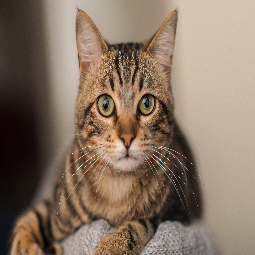

In [14]:
pic.resize((255,255))

### Predictions

In [22]:
pred_img = learn.predict('cat.jpg')

In [23]:
len(pred_img)

3

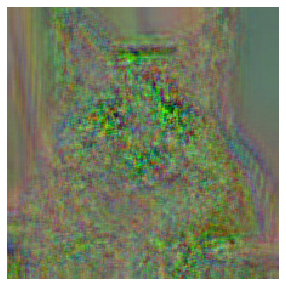

In [24]:
pred_img[0].show()

In [25]:
learn.load('stage1')

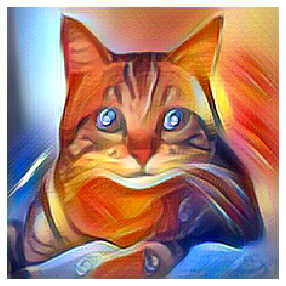

In [26]:
pred_img2 = learn.predict('cat.jpg')
pred_img2[0].show()

### Get the image

In [17]:
from torchvision.transforms import transforms
pil_t = transforms.ToPILImage()

In [18]:
DataBlock.__module__

'fastai2.data.block'

In [19]:
dblock2 = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(0.1, seed=42),
                   item_tfms=[Resize(224)],
                   )

dls2 = dblock2.dataloaders(path, bs=4)

##### How to line up transformed and un-transformed from one batch

In [20]:
# these don't line up and they always change...perhaps a yield?
dls.get_idxs()[0], dls2.get_idxs()[0]

(14457, 16435)

In [23]:
dls.shuffle

True

In [21]:
dls.get_idxs()[-1], dls2.get_idxs()[-1]

(13857, 3385)

In [33]:
batch_model = dls.one_batch()
batch_orig =  dls2.one_batch()

pic_model = batch_model[0][0].cpu()
pic_orig =   batch_orig[0][0].cpu()

pil_model = pil_t(pic_model.cpu())
pil_orig =  pil_t(pic_orig.cpu())

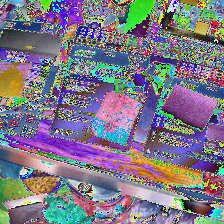

In [34]:
pil_model

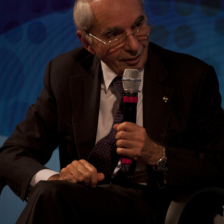

In [35]:
pil_orig

### Get a Single Image

In [109]:
one_batch = dls.one_batch()

print(len(one_batch), len(one_batch[0]))

pic = one_batch[0][0]

print(pic.shape)
print(type(pic))

2 4
torch.Size([3, 224, 224])
<class 'torch.Tensor'>


##### Got the image plotted but distorted

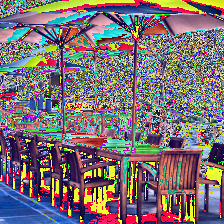

In [110]:
from torchvision.transforms import transforms
pil_t = transforms.ToPILImage()
pil_img = pil_t(pic.cpu())
pil_img

##### A true representation of the image
new data block doesn't apply a transform to the image

In [116]:
dblock2 = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(0.1, seed=42),
                   item_tfms=[Resize(224)],
                   )

dls2 = dblock2.dataloaders(path, bs=4)

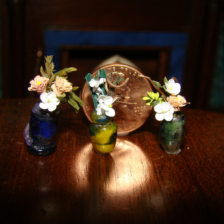

In [117]:
pic = dls2.one_batch()[0][0]
pil_img = pil_t(pic.cpu())
pil_img

In [144]:
# also a recommended method
x = next(iter(dls))

##### Other methods that don't work

(482, 640)


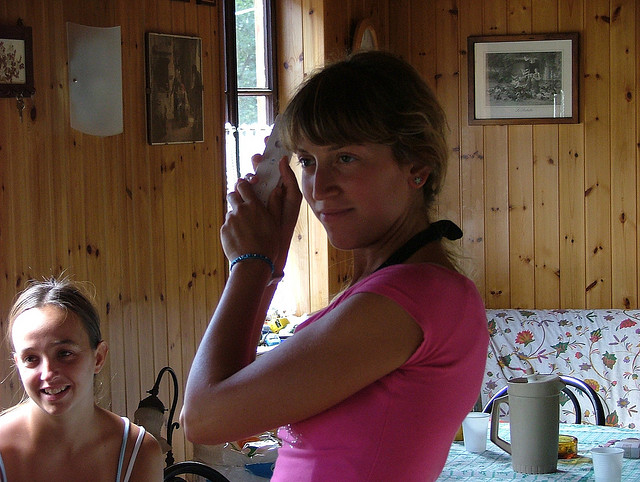

In [89]:
#get the full original image
pic = dls.dataset[0][0]
print(pic.shape)
pic

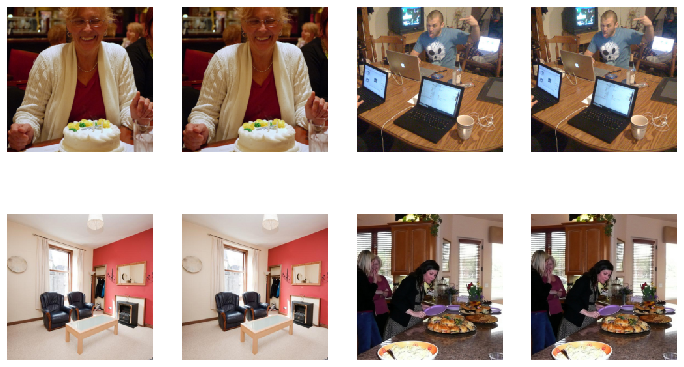

In [75]:
# get a transformed batch
dls.show_batch()